# Hard geometry problem - reprojection of ellipses

This notebook explains the math that underlies the ring modeling tool.  Scroll down below the function definitions to read the problem statement and solutions implemented in this tool.

In [2]:
from scipy.spatial.transform import Rotation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [3]:
# project them back to making z-plane zero
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def vector_magnitude(a):
    '''expects np array of shape (x, 3) or (x, 2)
    corresponding to a bunch of vectors
        this is a bit faster than using np.linalg.norm'''
    if len(a.shape) == 1:
        return np.sum(np.sqrt(a*a))
    return np.sqrt((a*a).sum(axis=1))

def plane_project(x,z):
    '''projects x onto plane where z is normal vector to that plane'''
    z = normalize(z)
    return np.cross(z, np.cross(x, z))

def make_rot(i,omega,w):
    '''
    use i, omega, and w as Euler rotation angles and return a rotation object
    see: https://en.wikipedia.org/wiki/Euler_angles#Conventions_by_intrinsic_rotations
    '''
    return Rotation.from_euler('zxz', [w, i, omega], degrees=True)
    

def rotate_and_project(vec,rot,proj_plane=[0,0,1]):
    '''
    use i, omega, and w as Euler rotation angles to project a vector
    first into 3-D then onto a 2-D plane
    '''
    return plane_project(rot.apply(vec), proj_plane)

In [4]:
def vector_ellipse(u, v, t, origin=np.array([0,0,0])):
    '''
    https://math.stackexchange.com/questions/3994666/parametric-equation-of-an-ellipse-in-the-3d-space#:~:text=In%20the%20parametric%20equation%20x,a%20point%20with%20minimum%20curvature.
    u, v are vectors corresponding to the vectorized a, b
    t are the data points from 0 to 2pi
    '''
    u = u[np.newaxis,:]
    v = v[np.newaxis,:]
    t = t[:,np.newaxis]
    #print(u*np.cos(t))
    
    return origin + u*np.cos(t) + v*np.sin(t)

def project_ellipse(a,e,i,omega,w,n=100, origin = np.array([0,0,0]), proj_plane = [0,0,1]):
    '''
    make a projection of an ellipse with the given params using i,omega,w as Euler rotation angles
    a: any distance unit
    e: unitless
    i, omega, w: assume degrees
    n: number of points in ellipse circumference
    origin: units of a, expects array
    '''
    
    # simple pre-calculations
    b = a*np.sqrt(1-e**2)
    c = a*e
    f0 = np.array([origin[0] + c, origin[1], 0]) # foci
    f1 = np.array([origin[0] - c, origin[1], 0])
    a_vec = np.array([a,0,0])
    b_vec = np.array([0,b,0])
    
    # apply projections to a, b, f0, f1
    rot = make_rot(i,omega,w)
    f0p = rotate_and_project(f0, rot, proj_plane=proj_plane)
    f1p = rotate_and_project(f1, rot, proj_plane=proj_plane)
    a_vec_p = rotate_and_project(a_vec, rot, proj_plane=proj_plane)
    b_vec_p = rotate_and_project(b_vec, rot, proj_plane=proj_plane)
    
    # make and project ellipse circumference
    t = np.linspace(0,2*np.pi,n)
    ell = vector_ellipse(a_vec, b_vec, t, origin=origin)
    ell_p = rotate_and_project(ell, rot, proj_plane=proj_plane)
    
    # dict of outputs
    output = {'a':a_vec_p,
             'b':b_vec_p,
             'f0':f0p,
             'f1':f1p,
             'ell':ell_p}
    
    return output

def calc_abtheta(ell):
    '''
    given vectors defining the circumference of an ellipse, 
    find corresponding values of a, b, and theta
    using the fact that locations of a, b are max, min of ellipse vectors
    '''
    mag = vector_magnitude(ell)
    a, b = np.max(mag), np.min(mag)
    wherea = np.argmax(mag)
    whereb = np.argmin(mag)
    xa, ya, _ = ell[wherea]
    #xb, yb, _ = ell_proj[whereb]
    theta = np.rad2deg(np.arctan(ya/xa))
    
    return a, b, theta

# Problem Statement / Background

The Keplerian orbital elements are
- a: semimajor axis
- e: eccentricity
- i: inclination
- $\Omega$: longitude of ascending node
- $\omega$: argument of periapsis
- $\nu$: true anomaly. this is ignored for rings

The image below gives a visualization of how each of these elements are defined. Together, they uniquely specify an elliptical orbit in any orientation in 3-D space relative to a reference plane.  These elements are what we get from the planetary ring node.

The [photutils](https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAnnulus.html#photutils.aperture.EllipticalAnnulus) package has been immensely useful for making models of all sorts of planetary objects for a few reasons
- it gets sub-pixel geometry correct
- it can be used to extract fluxes from a masked region
- it can be used to build model rings

However, photutils defines ellipses in 2-D only, requiring the parameters
- a: semimajor axis
- b: semiminor axis
- $\theta$: rotation angle of a

So the challenge is to take an arbitrary ellipse defined in 3-D using the Keplerian orbital elements, translate it into a 2-D projection on the plane of the sky, and find a, b, $\theta$ of that new ellipse.

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Orbit1.svg/1920px-Orbit1.svg.png", width=600, height=600)

# why this problem is hard

I tried a few things to get this to work.  Below, I discuss my thinking about this problem before coming to the eventual solution.  Not to editorialize too much in a tutorial, but I think it can be helpful and important to still discuss solutions that fail.  If you don't care, just skip to Idea 3.


## idea 1: just project a and b

It's possible to define vectors $\vec{a} = [a,0,0]$ and $\vec{b}=[0,b,0]$. My idea was, if I can just rotate these and then project them onto the sky plane, I'll know the final a and b, and use their orientations to compute $\theta$. Maybe you can already guess why this will fail, but let's go through it anyway.

The three angles i, $\Omega$, and $\omega$ are known as [Euler angles](https://en.wikipedia.org/wiki/Euler_angles#Conventions_by_intrinsic_rotations). Three Euler angles define an arbitrary rotation in a 3-D space, but the second rotation axis depends on the first rotation axis, and the third rotation axis on the second rotation axis. Luckily there's a [scipy package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html) to do the geometry for me: it converts Euler rotations into rotation matrices that can be applied to the vectors.

The steps are:
1. define an ellipse in the reference plane with just a and e
2. translate Euler angles i, $\Omega$, $\omega$ into a rotation matrix
3. multiply vectorized a, b by rotation matrix
4. project vectors back into the reference plane by taking cross product with $\hat{z}$

In fact, if we write down the vector equation for an ellipse in 3-D, we can apply this procedure to every point on the ellipse to make pretty plots. That equation is:

$\vec{E} = \vec{a}\cos t + \vec{b}\sin t + \vec{O}$

with $\vec{O}$ the origin and $t$ from 0 to $2\pi$ as the times within one period, or the range of angles around a circle. 

Let's try projecting and see what happens.

In [6]:
# define a Keplerian ellipse. omega, i, w define an Eulerian rotation
a = 51149 #km
e = 0.5
i = 45.
omega = 60.
w = 30.
n = 200
b = a*np.sqrt(1-e**2)
c = a*e
origin = np.array([0,0,0])
f0 = np.array([origin[0] + c, origin[1], 0]) # foci
f1 = np.array([origin[0] - c, origin[1], 0])

In [7]:
## rotation and projection of a, b vectors

# rotate vector into plane based on these angles
rot = Rotation.from_euler('zxz', [w, i, omega], degrees=True)

a_vec = np.array([a,0,0])
b_vec = np.array([0,b,0])
a_rot = rot.apply(a_vec)
b_rot = rot.apply(b_vec)
f0_rot = rot.apply(f0)
f1_rot = rot.apply(f1)

#print(rot.as_matrix())
#print(rot.as_euler('xyz', degrees=True))

# project them back to making z-plane zero
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def plane_project(x,z):
    '''projects x onto plane where z is normal vector to that plane'''
    z = normalize(z)
    return np.cross(z, np.cross(x, z))

proj_plane = np.array([0,0,1])
a_proj, b_proj = plane_project(a_rot, proj_plane), plane_project(b_rot, proj_plane)
f0_proj = plane_project(f0_rot, proj_plane)
f1_proj = plane_project(f1_rot, proj_plane)
print(a_proj, a_rot)
print(b_proj, b_rot)
print(np.dot(a_proj, b_proj), np.dot(a_rot, b_rot)) 

[ 6487.04783238 47403.70118773    -0.        ] [ 6487.04783238 47403.70118773 18083.90237546]
[-34565.7616296   -5617.94821841      0.        ] [-34565.7616296   -5617.94821841  27125.85356318]
-490541287.68749994 0.0


In [8]:
# 3-D plot of that
def vec3to6(origin, vec):
    return np.concatenate([np.array(origin), np.array(vec)])

vecs1 = np.array([vec3to6(origin, a_vec), vec3to6(origin, b_vec)])
vecs2 = np.array([vec3to6(origin, a_rot), vec3to6(origin, b_rot)])
vecs3 = np.array([vec3to6(origin, a_proj), vec3to6(origin, b_proj)])

colors = ['red', 'blue', 'black']
labels = ['original', 'rotated', 'projected']

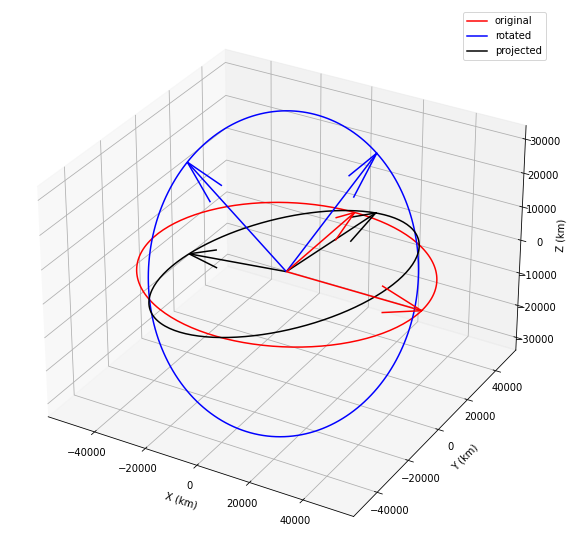

In [9]:
# try to make vectorized ellipses and rotate them
origin = np.array([0,0,0])
t = np.linspace(0,2*np.pi,n)

ell = vector_ellipse(a_vec, b_vec, t)
ell_rot = rot.apply(ell)
ell_proj = plane_project(ell_rot,proj_plane)

'''
# test if function definition works the same as these manual steps
# looks like it does work
output = project_ellipse(a,e,i,omega,w,n=n, origin = np.array([0,0,0]), proj_plane = [0,0,1])
print(np.allclose(ell_proj, output['ell']))
print(np.allclose(a_proj, output['a']))
print(np.allclose(b_proj, output['b']))
'''

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(ell.T[0], ell.T[1], ell.T[2], color = 'red', label = 'original')
ax.plot(ell_rot.T[0], ell_rot.T[1], ell_rot.T[2], color = 'blue', label = 'rotated')
ax.plot(ell_proj.T[0], ell_proj.T[1], ell_proj.T[2], color = 'k', label = 'projected')
for j,vecs in enumerate([vecs1, vecs2, vecs3]):
    X, Y, Z, U, V, W = zip(*vecs)
    ax.quiver(X, Y, Z, U, V, W, color=colors[j])

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()
plt.show()
plt.close()

In the image above, the original, red ellipse is in the x,y plane. It is then rotated using the Euler angles to become the blue ellipse. This ellipse has the same area as the original ellipse, even though the plotting software makes it look larger. Then the rotated ellipse is projected back down into the x,y plane to make a new ellipse (black).

Let's take a look at the red and black ellipses in 2-D space:

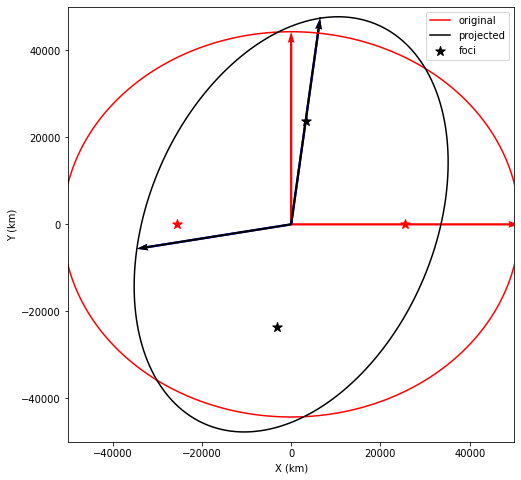

In [10]:
# make a 2-D projection of the same
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(ell.T[0], ell.T[1], color = 'red', label = 'original')
#ax.plot(ell_rot.T[0], ell_rot.T[1], color = 'blue', lw=5, linestyle=':', label = 'rotated') #just checking
ax.plot(ell_proj.T[0], ell_proj.T[1], color = 'k', label = 'projected')
for j,vecs in enumerate([vecs1, vecs2, vecs3]):
    X, Y, Z, U, V, W = zip(*vecs)
    ax.quiver(X, Y, U, V, color=colors[j], angles='xy', scale_units='xy', scale=1, width=0.005)
ax.scatter([f0[0], f1[0]], [f0[1],f1[1]], color = 'red', marker = '*', s = 100)
ax.scatter([f0_proj[0], f1_proj[0]], [f0_proj[1],f1_proj[1]], color = 'k', marker = '*', s = 100, label='foci')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_xlim([-5e4, 5e4])
ax.set_ylim([-5e4, 5e4])
ax.legend()
plt.show()

Pretty neatly done, but the problem is obvious: the new a, b for this ellipse are NOT the projections of the old a, b. For one thing, b is not perpendicular to a, and a does not point to the actual semimajor axis.  In fact, if the inclination is large, then the longer vector might actually be b, and the shorter vector a!

So how can we get the actual a, b, and theta of the black ellipse?
- a is the length of the vector with the largest magnitude
- $\theta$ is the direction of that vector
- b is the vector with the smallest magnitude

## Idea 2: analytical calculation

There must be a way to calculate these from first principles somehow. But you would need to do the following steps analytically:
- define the rotation matrix in terms of i, $\Omega$, and $\omega$ for the general case
- apply the rotation matrix to the equation of the ellipse itself
- do the cross product to project
- take the derivative of the resulting formula to find the maximum and its vector location

This sounds like a ton of math! I pretty much stopped here with this idea, once I realized it seemed like a big lift. However, this is the clear "best" solution and if someone were keen to solve it, I'd love to merge it into this software.

## Idea 3: reproject entire ellipses

Instead, one can just reproject the a bunch of points on the ellipse like I was already doing to make the pretty plots above, and then find the largest magnitude vector just based on which point is farthest from the center. At this stage in my thinking, I was pretty concerned that this was a bad method because of the computational cost; I was worried that it would be impossible to, say, apply this in an MCMC framework, and especially when I knew Idea 2 *should* work in principle.

but I got it running anyway:

In [11]:
# re-make ellipse projection with small n to illustrate problem with small n
n = 14
true_params = project_ellipse(a,e,i,omega,w,n=int(n), origin = np.array([0,0,0]), proj_plane = [0,0,1])
vecs3 = np.array([vec3to6(origin, true_params['a']), vec3to6(origin, true_params['b'])])
ell_proj = true_params['ell']
a_i,b_i,theta_i = calc_abtheta(ell_proj)

# compute vector a, b given scalars and theta
xa, ya = a_i*np.cos(np.deg2rad(theta_i)), a_i*np.sin(np.deg2rad(theta_i))
xb, yb = b_i*np.cos(np.deg2rad(theta_i+90)), b_i*np.sin(np.deg2rad(theta_i+90))

/var/folders/g0/r491pzqx4kx0tfmpx8970ntm0000gn/T/ipykernel_55489/2730423656.py:15: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  epatch = Ellipse((0,0),2*a_i,2*b_i,theta_i, ec='green', fc='None', lw=2, label='derived')


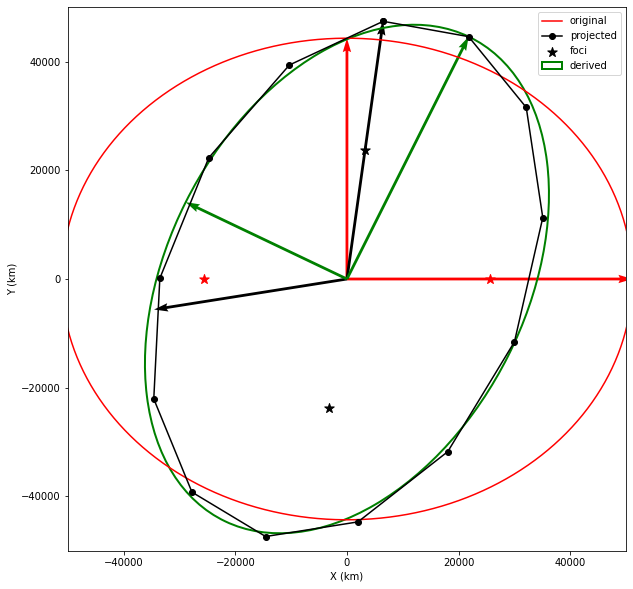

In [12]:
# check this against the projected ellipse
colors = ['red', 'black']
from matplotlib.patches import Ellipse
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(ell.T[0], ell.T[1], color = 'red', label = 'original')
#ax.plot(ell_rot.T[0], ell_rot.T[1], color = 'blue', lw=5, linestyle=':', label = 'rotated') #just checking
ax.plot(ell_proj.T[0], ell_proj.T[1], color = 'k', label = 'projected', marker='o')
for j,vecs in enumerate([vecs1, vecs3]):
    X, Y, Z, U, V, W = zip(*vecs)
    ax.quiver(X, Y, U, V, color=colors[j], angles='xy', scale_units='xy', scale=1, width=0.005)
ax.scatter([f0[0], f1[0]], [f0[1],f1[1]], color = 'red', marker = '*', s = 100)
ax.scatter([f0_proj[0], f1_proj[0]], [f0_proj[1],f1_proj[1]], color = 'k', marker = '*', s = 100, label='foci')
    
epatch = Ellipse((0,0),2*a_i,2*b_i,theta_i, ec='green', fc='None', lw=2, label='derived')
ax.add_patch(epatch)
ax.quiver([0,0],[0,0],[xa,xb],[ya,yb], color='green', angles='xy', scale_units='xy', scale=1, width=0.005)


ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_xlim([-5e4, 5e4])
ax.set_ylim([-5e4, 5e4])
ax.legend()
plt.show()

This works, but you need a large number n of points on the ellipse circumference. I ran this with a small value of n on purpose to illustrate what happens if you don't. Notice that the "derived" semimajor axis (green vector) points directly at one of the black data points. So the accuracy depends on the sampling.

Below, I re-run the same thing with n=500.

/var/folders/g0/r491pzqx4kx0tfmpx8970ntm0000gn/T/ipykernel_55489/3921313529.py:26: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  epatch = Ellipse((0,0),2*a_i,2*b_i,theta_i, ec='green', fc='None', lw=2, label='derived')


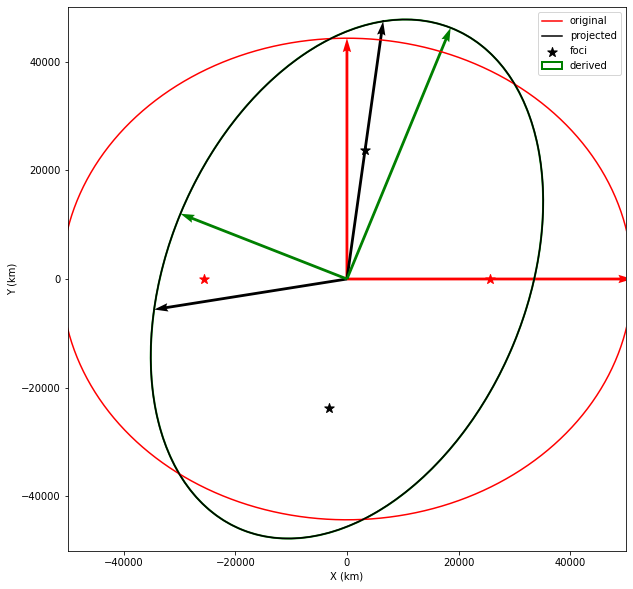

In [13]:
# once more, but with larger n
n = 500
true_params = project_ellipse(a,e,i,omega,w,n=int(n), origin = np.array([0,0,0]), proj_plane = [0,0,1])
vecs3 = np.array([vec3to6(origin, true_params['a']), vec3to6(origin, true_params['b'])])
ell_proj = true_params['ell']
a_i,b_i,theta_i = calc_abtheta(ell_proj)

# compute vector a, b given scalars and theta
xa, ya = a_i*np.cos(np.deg2rad(theta_i)), a_i*np.sin(np.deg2rad(theta_i))
xb, yb = b_i*np.cos(np.deg2rad(theta_i+90)), b_i*np.sin(np.deg2rad(theta_i+90))

# check this against the projected ellipse
colors = ['red', 'black']
from matplotlib.patches import Ellipse
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(ell.T[0], ell.T[1], color = 'red', label = 'original')
#ax.plot(ell_rot.T[0], ell_rot.T[1], color = 'blue', lw=5, linestyle=':', label = 'rotated') #just checking
ax.plot(ell_proj.T[0], ell_proj.T[1], color = 'k', label = 'projected')
for j,vecs in enumerate([vecs1, vecs3]):
    X, Y, Z, U, V, W = zip(*vecs)
    ax.quiver(X, Y, U, V, color=colors[j], angles='xy', scale_units='xy', scale=1, width=0.005)
ax.scatter([f0[0], f1[0]], [f0[1],f1[1]], color = 'red', marker = '*', s = 100)
ax.scatter([f0_proj[0], f1_proj[0]], [f0_proj[1],f1_proj[1]], color = 'k', marker = '*', s = 100, label='foci')
    
epatch = Ellipse((0,0),2*a_i,2*b_i,theta_i, ec='green', fc='None', lw=2, label='derived')
ax.add_patch(epatch)
ax.quiver([0,0],[0,0],[xa,xb],[ya,yb], color='green', angles='xy', scale_units='xy', scale=1, width=0.005)


ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_xlim([-5e4, 5e4])
ax.set_ylim([-5e4, 5e4])
ax.legend()
plt.show()

Indeed it looks pretty good! We get a, b, and $\theta$ spot-on, at least upon visual inspection.

However, the location of $a$ might be wrong by an angle of up to (360 degrees / 2n) according to my back-of-the-envelope calculations.

For Keck or ALMA observations, which have something like 50 mas resolution, one resolution element is a few hundred km (say 400 km).  With a ring circumference around of 4e6 km for Uranus, we need n=500 just to get within one resolution element. If we wanted, say, 1/20 of a resolution element, we would need n=1e4.

This sampling problem will be the most serious for near-circular and face-on orbits because all the vectors defining the circumference of the ellipse are nearly the same length.

Below, I change the value of n from 3 to 1e6 and check the accuracy of the solution for a much more circular ellipse. I changed the inclination to be 3 degrees and the eccentricity to be just 0.01

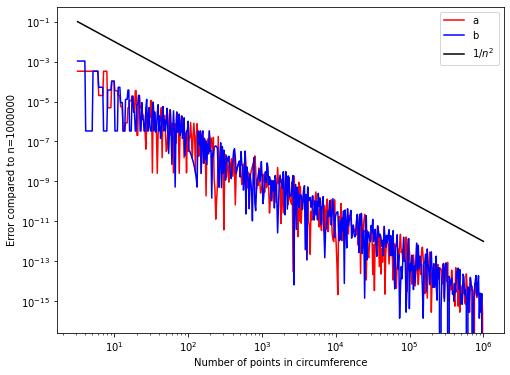

Uncertainty in a, b at n = 10000.0: (7.832706544324673e-11, 4.2821722113521136e-11)


In [14]:
## TO DO: change this sensitivity test to compute theta for an ellipse 
#         with special geometry such that we know the theoretical answer

# test the sensitivity of a, b, and theta to the choice of n
a2, e2, i2, omega2, w2 = a, 0.01, 3, omega, w
nvals = np.logspace(0.5,6,500)
alist, blist, thetafrac = [], [], []
for n in nvals:
    
    true_params = project_ellipse(a2,e2,i2,omega2,w2,n=int(n), origin = np.array([0,0,0]), proj_plane = [0,0,1])
    a_i,b_i,theta_i= calc_abtheta(true_params['ell'])
    a0, b0 = vector_magnitude(true_params['a']), vector_magnitude(true_params['b'])
    alist.append(a_i)
    blist.append(b_i)

    
fraca = np.abs(alist - alist[-1])/alist[-1]
fracb = np.abs(blist - blist[-1])/blist[-1]
fig, ax = plt.subplots(1,1, figsize=(8,6))

plt.loglog(nvals, fraca, color = 'red', label='a')
plt.loglog(nvals, fracb, color = 'blue', label='b')
plt.loglog(nvals, 1.0/nvals**2, color = 'k', label=r'$1/n^2$')
plt.xlabel('Number of points in circumference')
plt.ylabel(f'Error compared to n={int(nvals[-1])}')
plt.legend()
plt.show()

ncut = 1.0e4
print(f'Uncertainty in a, b at n = {ncut}: {np.max(fraca[nvals>ncut]), np.max(fracb[nvals>ncut])}')

It looks like in practice, the error is smaller than n/2, going as roughly 1/n^2. But again this may depend on the shape of the ellipse, with geometries very near to circles being the biggest problems.  I will have to think about this more. Either way, the main question is, how expensive is this to run if we need n = 1e4 to be sure of our results? Does idea 3 work in practice?

below, I set up a timing test in which I make several thousand ellipses with random parameters, each with n=1e4, and calculate a, b, and theta of the projection.

In [15]:
# timing test with n = 10000
from datetime import datetime
then = datetime.now()
nr = 1e4
niters = int(1e4)
for j in range(niters):
    if j % 1e4 == 0:
        print(j)
    ar = np.random.uniform(1.0e4, 1.0e5)
    er = np.random.uniform(0.0, 0.9)
    ir = np.random.uniform(0.0, 90.)
    omegar = np.random.uniform(0.0, 90.)
    wr = np.random.uniform(0.0, 90.)
    #print(a,e,i,omega,w)
    true_params = project_ellipse(ar,er,ir,omegar,wr,n=int(nr), origin = np.array([0,0,0]), proj_plane = [0,0,1])
    a_ir,b_ir,theta_ir= calc_abtheta(true_params['ell'])

now = datetime.now()
total = (now - then).total_seconds()
print(f'total time for {niters} iters was {total} seconds')
print(f'that is {total/niters} seconds per iter')

0
total time for 10000 iters was 11.054984 seconds
that is 0.0011054984 seconds per iter


# conclusion

On my machine, it takes 1 millisecond to compute the vector rotation and projection of 1e4 points on an ellipse. Computers are fast at vector math! So this would be completely reasonable to use in an MCMC framework, and in fact, I wouldn't be surprised if the rate-limiting step were the computation of fractional pixels as the ellipse was cast into a 2-D image by photutils, especially for large images like we get with ALMA.

This means that I can go ahead with using photutils to make model rings, and skip all the annoying vector math required to do this "right." Maybe someday it'll be needed, but given that I have something that works, I am not going to bash my head against that particular wall right now.

# Double rotation for real ring systems

In real ring systems, the conventional way to express the orientation of a ring on the sky is by defining two separate rotations: the orientation of a ring relative to the plane of the system, and another of the system relative to the observer. Here I will attempt to turn these numbers into a single (a, e, i, omega, w) so the reprojection needs to be run only once.

Let us take the Planetary Ring Node output for a random day, June 12 2013 at 00:00 UTC.  That looks like:

     Ring          Pericenter   Ascending Node (deg, from ring plane ascending node)
     Alpha         116.636      311.963
     Beta          116.950       97.807
     Eta             0.000        0.000
     Gamma         275.337        0.000
     Delta           0.000        0.000
     Epsilon       266.913        0.000
 
Ring sub-solar latitude (deg): -21.35666  (-21.36995  to -21.34336)
   
Ring plane opening angle (deg): -24.04446  (lit)
  
Ring center phase angle (deg):   2.71395
   
Sub-solar longitude (deg):   2.77759  from ring plane ascending node
       
Sub-observer longitude (deg):   2.35115

North pole angle of Uranus (deg): 255.1941

In [16]:
def double_rotate_2(vec, params_ring, params_sys):
    '''
    rotate ring, apply, rotate system, apply
    
    params_ring = [w, i, omega] in degrees for that ring
    params_sys = [w, i, omega] in degrees for the ring plane w.r.t. observer
    '''
    rot_ring = Rotation.from_euler('zxz', params_ring, degrees=True)
    vec_ring = rot_ring.apply(vec)
    rot_sys = Rotation.from_euler('zxz', params_sys, degrees=True)
    vec_out = rot_sys.apply(vec_ring)
    return vec_out


def double_rotate(vec, params_ring, params_sys):
    '''
    rotate system * rotate ring
    
    params_ring = [w, i, omega] in degrees for that ring
    params_sys = [w, i, omega] in degrees for the ring plane w.r.t. observer
    '''
    rot_ring = Rotation.from_euler('zxz', params_ring, degrees=True)
    rot_sys = Rotation.from_euler('zxz', params_sys, degrees=True)
    rot_total = rot_sys * rot_ring
    vec_out = rot_total.apply(vec)
    return vec_out

# the two definitions of double_rotate yield identical results, but multiplying the rotations is faster!
    
    
def project_ellipse_double(a, e, params_ring, params_sys, origin = np.array([0,0,0]), n=50, proj_plane = [0,0,1]):
    
    b = a*np.sqrt(1-e**2)
    c = a*e
    f0 = np.array([origin[0] + c, origin[1], 0]) # foci
    f1 = np.array([origin[0] - c, origin[1], 0])
    a_vec = np.array([a,0,0])
    b_vec = np.array([0,b,0])
    
    # apply double rotation to a, b, f0, f1
    a_rot = double_rotate(a_vec, params_ring, params_sys)
    b_rot = double_rotate(b_vec, params_ring, params_sys)
    f0_rot = double_rotate(f0, params_ring, params_sys)
    f1_rot = double_rotate(f1, params_ring, params_sys)
    
    # project these
    a_proj, b_proj = plane_project(a_rot, proj_plane), plane_project(b_rot, proj_plane)
    f0_proj = plane_project(f0_rot, proj_plane)
    f1_proj = plane_project(f1_rot, proj_plane)
    
    
    # make and project ellipse circumference
    t = np.linspace(0,2*np.pi,n)
    ell = vector_ellipse(a_vec, b_vec, t, origin=origin)
    ell_rot = double_rotate(ell, params_ring, params_sys)
    ell_p = plane_project(ell_rot, proj_plane)
    
    # dict of outputs
    output = {'a':a_proj,
             'b':b_proj,
             'f0':f0_proj,
             'f1':f1_proj,
             'ell':ell_p}
    
    return output

In [39]:
np_ang = 255.1941 #apparent north-pole position angle (ccw w.r.t. reference-frame north pole) for the parent body from Horizons
B = -24.04446 #ring system opening angle
a_eps = 51149
e_eps = 0.0079
origin = np.array([0,0,0])
params_eps = [266.913, 0.0, 0.0] #[w, i, omega]
#params_eps = [202., 0.0, 0.0]

a_alpha = 44718
e_alpha = 0.0040
params_alpha = [116.636, 0.015, 311.963] #[w, i, omega]

i_sys = -90 + B
omega_sys = np_ang
w_sys = 0
params_sys = [w_sys, i_sys, omega_sys]
#params_sys = [0, 0, 0]

ell_alpha = project_ellipse_double(a_alpha, e_alpha, params_alpha, params_sys)
ell_eps = project_ellipse_double(a_eps, e_eps, params_eps, params_sys)

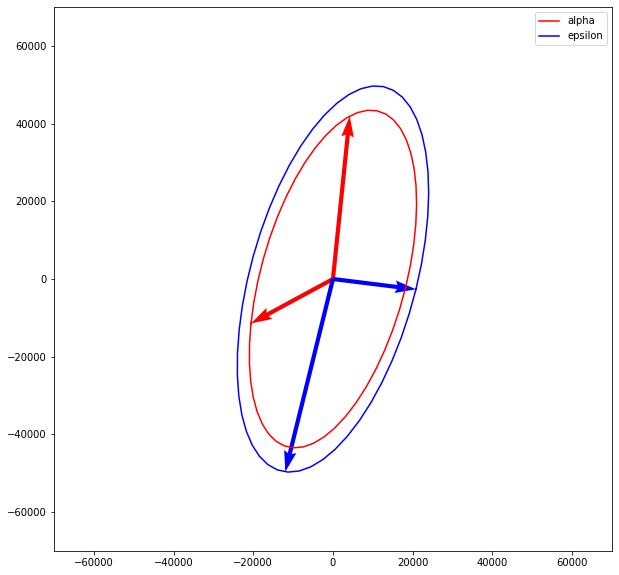

In [40]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
vecs_alpha = np.array([vec3to6(origin, ell_alpha['a']), vec3to6(origin, ell_alpha['b'])])
vecs_eps = np.array([vec3to6(origin, ell_eps['a']), vec3to6(origin, ell_eps['b'])])

colors = ['red', 'blue']
for j,vecs in enumerate([vecs_alpha, vecs_eps]):
    X, Y, Z, U, V, W = zip(*vecs)
    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color=colors[j])
    
ax.plot(ell_alpha['ell'][:,0], ell_alpha['ell'][:,1], color = 'red', label = 'alpha')
ax.plot(ell_eps['ell'][:,0], ell_eps['ell'][:,1], color = 'blue', label = 'epsilon')
#ax.scatter(ell_alpha['f0'][0], ell_alpha['f0'][1], color = 'darkred')
#ax.scatter(ell_eps['f0'][0], ell_eps['f0'][1], color = 'skyblue')

ax.set_xlim([-7e4, 7e4])
ax.set_ylim([-7e4, 7e4])
ax.legend()
plt.show()